In [2]:
import os; os.chdir('..'); os.getcwd()

'/home/jupyter/master-thesis/src'

In [3]:
from jobs.specs.__dev import vaetarn_smth_dev as opts
from models.vae_tarn import VAETimeAlignedResNet
from pipeline.smth.databunch import SmthDataBunch
from models.engine import _prepare_batch
import constants as ct

import dataclasses as dc
import torch as th
import matplotlib.pyplot as plt
import numpy as np


In [4]:
def pic_show(_video):
    num = len(_video)
    fig = plt.figure(figsize=(16, 32), dpi=80)
    for i in range(1,num+1):
        sub = fig.add_subplot(1,num,i)
        sub.set_title(str(i))
        sub.axis('off')
        sub.imshow(_video[i-1])
    plt.show()

def un_normalize(_x):
    return _x * 255

def un_standardize(_x):
    means = th.tensor(ct.IMAGE_NET_MEANS).reshape((1, 3, 1, 1))
    stds = th.tensor(ct.IMAGE_NET_STDS).reshape((1, 3, 1, 1))
    
    return _x * stds + means

In [5]:
opts.trainer_opts.optimizer_opts.lr = 0.001
opts.valid_dl_opts.batch_size = 1
opts.dev_dl_opts.batch_size = 1
opts.trainer_opts.criterion_opts.mse_factor = 1.0
opts.trainer_opts.criterion_opts.ce_factor = 1.0
opts.trainer_opts.criterion_opts.kld_factor = 0.0
device = th.device('cuda' if th.cuda.is_available() else 'cpu')

model = VAETimeAlignedResNet(**dc.asdict(opts.model_opts)).to(device)
bunch = SmthDataBunch(opts.db_opts, opts.train_ds_opts, opts.dev_ds_opts, opts.valid_ds_opts, opts.train_dl_opts, opts.dev_dl_opts, opts.valid_dl_opts)
optimizer = opts.trainer_opts.optimizer(model.parameters(), **dc.asdict(opts.trainer_opts.optimizer_opts))
loss_fn = opts.trainer_opts.criterion(**dc.asdict(opts.trainer_opts.criterion_opts)).to(device)

# model.load_state_dict(th.load('../runs/dummy/smth/__dev/aetarn_smth_dev@1.0_1.0/best_model_44_acc@1=0.4027.pth', 
#                               map_location=device), strict=False)

model

VAETimeAlignedResNet(
  (spatial_encoder): VariationalSpatialResNetEncoder(
    (conv1): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layers): ModuleList(
      (0): Sequential(
        (0): SpatialResidualBlock(
          (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (downsample): Sequential(
            (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
       

In [8]:

batch = next(iter(bunch.valid_loader))
video, label = bunch.valid_set[0]
x, y = _prepare_batch(batch, device, False)


In [9]:

video, label


(Video 172305 (4x3x224x224), (6 Throwing something))

In [10]:

for epoch in range(300):
    model.train()
    optimizer.zero_grad()
    _recon, _pred, _latent, _mean, _log_var, _vote = model(x, inference=False, num_samples=1)
    mse, ce, kld = loss_fn(_recon, _pred.reshape(1, 30), x, y, _mean, _log_var)
    (mse + ce + kld).backward()
    print(f'EPOCH={epoch:03d} | CE={ce:.4f} | MSE={mse:.4f} | KLD={kld:.4f}')
    optimizer.step()


EPOCH=000 | CE=2.8610 | MSE=0.7238 | KLD=0.0000
EPOCH=001 | CE=0.1316 | MSE=0.5703 | KLD=0.0000
EPOCH=002 | CE=0.0000 | MSE=0.4737 | KLD=0.0000
EPOCH=003 | CE=0.0000 | MSE=0.4255 | KLD=0.0000
EPOCH=004 | CE=0.0000 | MSE=0.3890 | KLD=0.0000
EPOCH=005 | CE=0.0000 | MSE=0.3571 | KLD=0.0000
EPOCH=006 | CE=0.0000 | MSE=0.3225 | KLD=0.0000
EPOCH=007 | CE=0.0000 | MSE=0.2854 | KLD=0.0000
EPOCH=008 | CE=0.0000 | MSE=0.2553 | KLD=0.0000
EPOCH=009 | CE=0.0000 | MSE=0.2330 | KLD=0.0000
EPOCH=010 | CE=0.0000 | MSE=0.2118 | KLD=0.0000
EPOCH=011 | CE=1.1309 | MSE=0.1917 | KLD=0.0000
EPOCH=012 | CE=0.0000 | MSE=0.1747 | KLD=0.0000
EPOCH=013 | CE=0.0000 | MSE=0.1523 | KLD=0.0000
EPOCH=014 | CE=0.0000 | MSE=0.1325 | KLD=0.0000
EPOCH=015 | CE=0.0000 | MSE=0.1184 | KLD=0.0000
EPOCH=016 | CE=0.0000 | MSE=0.1057 | KLD=0.0000
EPOCH=017 | CE=0.0000 | MSE=0.0956 | KLD=0.0000
EPOCH=018 | CE=0.0000 | MSE=0.0881 | KLD=0.0000
EPOCH=019 | CE=0.0000 | MSE=0.0842 | KLD=0.0000
EPOCH=020 | CE=0.0000 | MSE=0.0797 | KLD

In [11]:

model.eval()
_recon, _pred, _latent, _mean, _log_var, _vote = model(x, inference=True, num_samples=10)


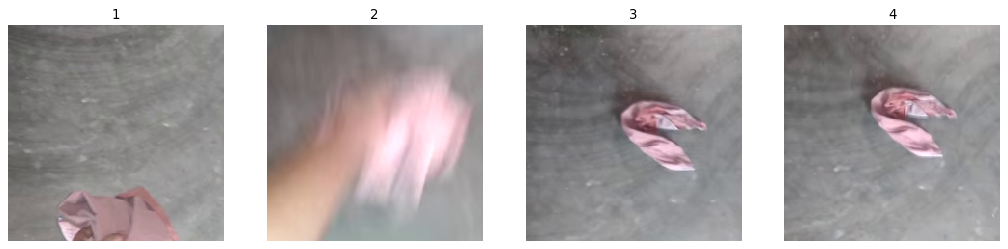

In [12]:

_in = video.data.astype(np.int).swapaxes(1,2).swapaxes(2,3)
pic_show(_in)


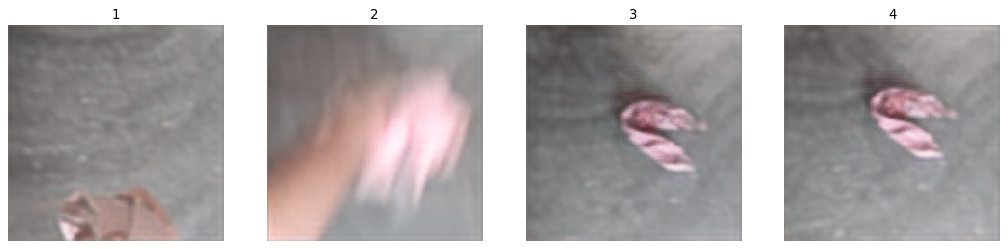

In [13]:

_rec = un_normalize(un_standardize(_recon.detach().cpu()))
_rec = _rec.numpy().reshape(4, 3, 224, 224).astype(np.int).swapaxes(1,2).swapaxes(2,3)
pic_show(_rec)


In [14]:

_recon.min(), _recon.max(), _rec.min(), _rec.max()


(tensor(-1.3368, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(2.5792, device='cuda:0', grad_fn=<MaxBackward1>),
 39,
 254)

In [15]:

un_standardize(_recon.detach().cpu()).min(), un_standardize(_recon.detach().cpu()).max()




(tensor(0.1566), tensor(0.9999))